# Get Started with DeltaXplainer

In this notebook, the goal will be to show you how to quickly setup and use the deltaxplainer library.

### First make sure deltaxplainer is installed

In [1]:
!pip install deltaxplainer

  Preparing metadata (setup.py) ... done
  Created wheel for deltaxplainer: filename=deltaxplainer-1.1-py3-none-any.whl size=5689 sha256=fdc678e2d820783cddd81f97c313d59a3c56aa9cfbe0d1d77c628930cde7dc10
  Stored in directory: /Users/adamrida/Library/Caches/pip/wheels/50/08/cc/b4004484cfaa888b05a0611069fb135f13394a78c76a148273
Successfully built deltaxplainer
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


## Toy example

In this section we will build two models F and G on the half moon dataset. The models are different but they are trained in the same data. Two plots are added to help visualize the differences

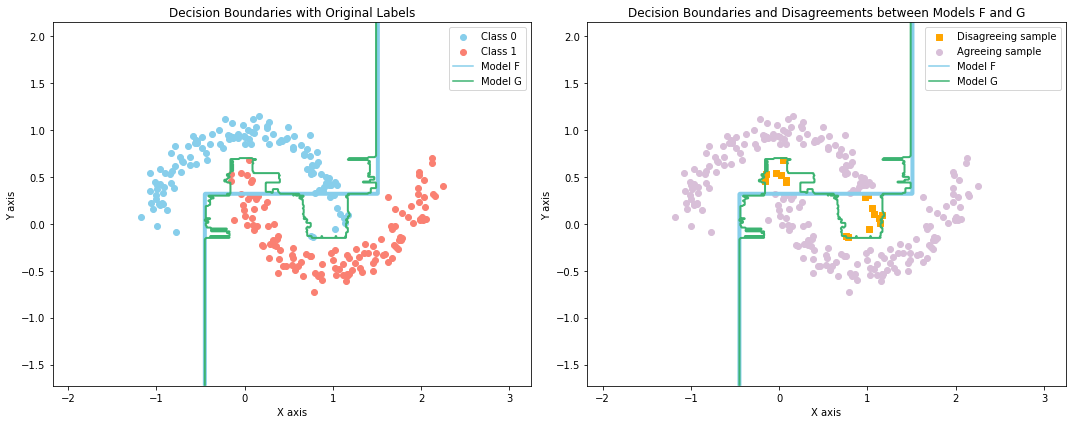

Model F:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       122
           1       0.94      0.92      0.93       128

    accuracy                           0.93       250
   macro avg       0.93      0.93      0.93       250
weighted avg       0.93      0.93      0.93       250


Model G:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       125
           1       1.00      1.00      1.00       125

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

# Generate two moons-like datasets
X, y = make_moons(n_samples=250, noise=0.1, random_state=1, shuffle=True)

# Train two different models
model_f = DecisionTreeClassifier(max_depth=3, random_state=42)
model_g = RandomForestClassifier(n_estimators=50, random_state=0)
model_f.fit(X, y)
model_g.fit(X, y)

# Concatenate the datasets
X_delta = X
y_delta_f = model_f.predict(X_delta)
y_delta_g = model_g.predict(X_delta)

disagreement_mask = y_delta_f != y_delta_g

report_f = classification_report(y_delta_f, y)
report_g = classification_report(y_delta_g, y)

# Decision Boundary for Model F and Model G with original labels
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Decision Boundary for Model F
x_min, x_max = X_delta[:, 0].min() - 1, X_delta[:, 0].max() + 1
y_min, y_max = X_delta[:, 1].min() - 1, X_delta[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
Z_f = model_f.predict(np.c_[xx.ravel(), yy.ravel()])
Z_f = Z_f.reshape(xx.shape)
axs[0].contour(xx, yy, Z_f, levels=[0.5], colors='skyblue', linewidths=4)

# Decision Boundary for Model G
Z_g = model_g.predict(np.c_[xx.ravel(), yy.ravel()])
Z_g = Z_g.reshape(xx.shape)
axs[0].contour(xx, yy, Z_g, levels=[0.5], colors='mediumseagreen', linewidths=2)

# Scatter plot for original labels
scatter_class_0 = axs[0].scatter(X_delta[y == 0, 0], X_delta[y == 0, 1], c='skyblue', label='Class 0', marker='o')
scatter_class_1 = axs[0].scatter(X_delta[y == 1, 0], X_delta[y == 1, 1], c='salmon', label='Class 1', marker='o')

axs[0].set_title('Decision Boundaries with Original Labels')
axs[0].set_xlabel('X axis')
axs[0].set_ylabel('Y axis')

# Combine the scatter plots in a single legend
axs[0].legend(handles=[scatter_class_0, scatter_class_1, plt.Line2D([], [], color='skyblue', markerfacecolor='none', marker='none', label='Model F'), plt.Line2D([], [], color='mediumseagreen', markerfacecolor='none', marker='none', label='Model G')])


# Decision Boundary for Model F and Model G with disagreements
# Decision Boundary for Model F
axs[1].contour(xx, yy, Z_f, levels=[0.5], colors='skyblue', linewidths=4)

# Decision Boundary for Model G
axs[1].contour(xx, yy, Z_g, levels=[0.5], colors='mediumseagreen', linewidths=2)

# Scatter plot for disagreements
sc1 = axs[1].scatter(X_delta[disagreement_mask][:, 0], X_delta[disagreement_mask][:, 1], c='orange', marker='s', label='Disagreeing sample')
sc2 = axs[1].scatter(X_delta[~disagreement_mask][:, 0], X_delta[~disagreement_mask][:, 1], c='thistle', marker='o', label='Agreeing sample')


axs[1].set_title('Decision Boundaries and Disagreements between Models F and G')
axs[1].set_xlabel('X axis')
axs[1].set_ylabel('Y axis')
axs[1].legend()
axs[1].legend(handles=[sc1, sc2, plt.Line2D([], [], color='skyblue', markerfacecolor='none', marker='none', label='Model F'), plt.Line2D([], [], color='mediumseagreen', markerfacecolor='none', marker='none', label='Model G')])


plt.tight_layout()
plt.show()
print(f'Model F:\n{report_f}\n\nModel G:\n{report_g}')

## Generating explanations

In [3]:
from deltaxplainer import DeltaXplainer
X = pd.DataFrame(X)
delta_model = DeltaXplainer().fit(X, model_f, model_g)


In [9]:
print(f"Model differs for the following {len(delta_model.segments)} segments: ")
i = 1
for segment in delta_model.segments:
    print(segment.replace("if ", f"Segment {i}:  ").replace("(","").replace(")","").replace(" 1 ", " Feature 1 ").replace(" 0 ", " Feature 0 "))
    i += 1
    

Model differs for the following 3 segments: 
Segment 1:  Feature 1 > -0.148 and Feature 1 <= 0.316 and Feature 0 > 0.569 and Feature 0 <= 1.397 then class: Feature 1 Coverage: 100.0% | based on 10 samples
Segment 2:  Feature 1 > 0.442 and Feature 1 <= 0.54 and Feature 0 <= 0.412 and Feature 0 > -0.5 then class: Feature 1 Coverage: 100.0% | based on 6 samples
Segment 3:  Feature 1 > 0.676 and Feature 1 <= 0.687 then class: Feature 1 Coverage: 100.0% | based on Feature 1 samples
